First, load the packages

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report



#models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB



import re

import spacy
import pandas as pd
import itertools as it 

nlp = spacy.load('en')


### Load functions

In [2]:
#import data
def importdf_sample_magnitude(order_of_magnitude=None, random_state=None):
    '''This function unpickle's the dataframe and returns a random sample of the DataFrame 
    of a specified magnitude. Allows user to specify the order of magnitude of a random 
    sampling of the DataFrame. The order_of_magnitude parameter defaults to None, in which 
    case the function returns the entire data frame. Otherwise, the user enters an integer 
    which determines the order of magnitude of the DataFrame. A random_state argument is
    included as an option.
    
    IN: integer
    OUT: DataFrame'''
    df = pd.read_pickle('df_text.pk')
    
    if order_of_magnitude:
        random_state = random_state
        sample_size = 10**order_of_magnitude
        df = df.sample(sample_size, random_state=random_state)
        return df
    else: 
        return df

In [3]:
def text_cleaner(df, variable='text_all', lemma_stopword=True, only_stopword=False):
    '''
    In: df
    Out: df
    
    Takes in a dataframe as an argument and goes through spaCy procedures to 
    tokenize, lemmatize and remove stop_words. Returns a cleaned string for each 
    review in the data set.
    '''
    cleaned_text = []
    
    regex = re.compile(r'<span.*\/span>|<br.\/>|<\/a >|<a href=.+?\s>')
    
    
    #takes avariable specified in arguments to iterate through
    for text in df[variable]:
        
        text = str(text).lower() #just to make sure it is a string
        
        text = re.sub(regex,'',text)

        text = nlp(text)
        
        if lemma_stopword==lemma_stopword:
            cleaned = [token.lemma_ for token in text if token.is_punct==False and token.is_stop==False]
            cleaned_text.append(' '.join(cleaned))
        elif only_stopword==only_stopword:
            cleaned = [token.text for token in text if token.is_punct==False and token.is_stop==False]
            cleaned_text.append(' '.join(cleaned))
        else: 
            cleaned_text = text
    print(len(cleaned_text))
    new_variable = f"{variable}_cleaned"
    df[new_variable] = cleaned_text
    return df

In [4]:
#standardize text
def std_scale(X_train, X_test):
    '''
    Applies standard scaler to training and testing features of the data set.
    '''
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_std = ss.transform(X_train)
    X_test_std = ss.transform(X_test)
    return X_train_std, X_test_std

### Load the Data

In [ ]:
#import samples and lematize
df_3 = importdf_sample_magnitude(3,random_state=42)
df_4 = importdf_sample_magnitude(4,random_state=42)
df_5 = importdf_sample_magnitude(5,random_state=42)

#clean the two text variables, text_all and Summary
df_3 = text_cleaner(df_3, variable='text_all', lemma_stopword=True, only_stopword=False)
df_4 = text_cleaner(df_4, variable='text_all', lemma_stopword=True, only_stopword=False)
df_5 = text_cleaner(df_5, variable='text_all', lemma_stopword=True, only_stopword=False)

1000
10000


## Model

In [ ]:
for item in df_3.groupby('Score')['Score'].value_counts().items():
    print(item[0][0])
    print(item[1])
y = [(df.positive==0).sum(),(df.positive==1).sum()]
x = ['0', '1']


### MultinomialNB
Ran the multinomialNB on count data. Does well. But I can standardize because it leads to negative values. I have not run the tfidf on this data yet because I have already determined that it does not work as well as the count data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:



#get count data
cnt_vctr = CountVectorizer()

#turn the training set into count data
X_train_cnt = cnt_vctr.fit_transform(X_train)

#turn the text data into count data
X_test_cnt = cnt_vctr.transform(X_test)

# X_train_cnt_std, X_test_cnt_std = std_scale(X_train_cnt.todense(),X_test_cnt.todense())
# can't standardize because centering on 0 causes negative values. Try Gaussian? 

#normalize (rather than standardize)

nrmr = Normalizer() 
X_train_cnt_nrm = nrmr.transform(X_train_cnt)
X_test_cnt_nrm = nrmr.transform(X_test_cnt)

mulNB_cnt = MultinomialNB()
mulNB_cnt.fit(X_train_cnt_nrm, y_train)

results_s = {}
results_s['multinomialNB_cnt']={}

results_s['multinomialNB_cnt']['accuracy'] = accuracy_score(y_test, mulNB_cnt.predict(X_test_cnt_nrm))

results_s['multinomialNB_cnt']['parameters']='defaults'



results_s['multinomialNB_cnt']['report'] = classification_report(y_test, mulNB_cnt.predict(X_test_cnt_nrm))
print(results_s['multinomialNB_cnt']['accuracy'])
print(results_s['multinomialNB_cnt']['report'])



Here we are supposed to see evidence that there is no gain in accuracy from standardization of the data. I'll go back and get this code running later if necessary.

### Singular Value Decomposition

In [13]:
'''This is the one that finally worked. '''
# import timeit
# %%timeit

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

X= df_4.text_all_cleaned.values
y= df_4.positive.values

X_train, X_test, y_train,  y_test = train_test_split(X, y)

estimators = [('tfidf', TfidfVectorizer()), 
              ('reduce_dim', TruncatedSVD()), 
              ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

param_distributions = dict(tfidf__max_df=[0.5, 0.6, 0.7, 0.8, 0.9], 
                  tfidf__min_df=[0.000001, 0.00001, 0.0001], 
                  tfidf__max_features=[1000, 1300, 1600], #Maybe do this with numbers over 100? 
                  tfidf__ngram_range=[(1,2)],
                  reduce_dim__n_components=[100, 140,200],
                  clf__C=[100, 1000, 10000, 100000], 
                  clf__gamma=[0.1, 0.01, 0.001, 0.0001])

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=cv, scoring='neg_log_loss',n_iter=25, n_jobs=-1)
grid.fit(X_train, y_train)
predictions = grid.predict(X_test)

print("The best parameters are {} with a log loss of {}".format(grid.best_params_, -1*grid.best_score_))
print('the accuracy of the model is {}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1e-06, 'tfidf__max_features': 1300, 'tfidf__max_df': 0.5, 'reduce_dim__n_components': 200, 'clf__gamma': 0.1, 'clf__C': 100} with a log loss of 0.4853318030606406
the accuracy of the model is 0.7892
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       908
           1       0.80      0.89      0.84      1592

    accuracy                           0.79      2500
   macro avg       0.78      0.75      0.76      2500
weighted avg       0.79      0.79      0.78      2500



Started going back down:

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 0.0001, 'tfidf__max_features': 1300, 'tfidf__max_df': 0.8, 'reduce_dim__n_components': 140, 'clf__gamma': 0.01, 'clf__C': 10000} with a log loss of 0.4929541792094349
the accuracy of the model is 0.7748
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       916
           1       0.80      0.86      0.83      1584

    accuracy                           0.77      2500
   macro avg       0.76      0.74      0.75      2500
weighted avg       0.77      0.77      0.77      2500




Lastest best model so far:

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1e-05, 'tfidf__max_features': 1300, 'tfidf__max_df': 0.7, 'reduce_dim__n_components': 140, 'clf__gamma': 0.01, 'clf__C': 10000} with a log loss of 0.49408760389845235
the accuracy of the model is 0.7852
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       909
           1       0.80      0.88      0.84      1591

    accuracy                           0.79      2500
   macro avg       0.77      0.75      0.76      2500
weighted avg       0.78      0.79      0.78      2500


New best model so far: 

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 0.0001, 'tfidf__max_features': 1200, 'tfidf__max_df': 0.7, 'reduce_dim__n_components': 130, 'clf__gamma': 0.001, 'clf__C': 10000} with a log loss of 0.4893221891715191
the accuracy of the model is 0.7752
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       891
           1       0.80      0.86      0.83      1609

    accuracy                           0.78      2500
   macro avg       0.76      0.74      0.75      2500
weighted avg       0.77      0.78      0.77      2500



Best model so far: 

The best parameters are {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 0.001, 'tfidf__max_features': 1000, 'tfidf__max_df': 0.6, 'reduce_dim__n_components': 140, 'clf__gamma': 0.0001, 'clf__C': 1000} with a log loss of 0.5023788452988097
the accuracy of the model is 0.7684
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       908
           1       0.76      0.93      0.84      1592

    accuracy                           0.77      2500
   macro avg       0.78      0.71      0.72      2500
weighted avg       0.77      0.77      0.75      2500


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)/10000

In [59]:
confusion = confusion_matrix(y_test,predictions)

In [60]:
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [61]:
print("Accuracy is {}".format((TP + TN)/(TP + FP + TN + FN)))

Accuracy is 0.7684


In [63]:
print("Sensitivity is {}".format(TP/(TP + FN)))
print("Sklearn's Sensitivity/Recall: {}".format(metrics.recall_score(y_test,predictions)))

Sensitivity is 0.9321608040201005
Sklearn's Sensitivity/Recall: 0.9321608040201005


In [64]:
print("Specificity is {}".format(TN/(TN + FP)))
print("No metric in Sklearn")

Specificity is 0.4812775330396476
No metric in Sklearn


In [65]:
print("False Positive {}".format(FP/(TP + FP)))

False Positive 0.24092071611253196


In [67]:
print("Precision score {}".format(TP/(TP+FP)))
print("Sklearn Precision Score: {}".format(metrics.precision_score(y_test,predictions)))

Precision score 0.759079283887468
Sklearn Precision Score: 0.759079283887468


Create a baseline for a dummy classifier.

In [68]:
from sklearn.dummy import DummyClassifier

X_dummy = np.array(np.linspace(0,100,10000))
print(len(X_dummy))
len(y)

10000


10000

In [69]:
dumb = DummyClassifier( strategy='most_frequent')

In [70]:
X_dummy = X_dummy.reshape(-1,1)

In [71]:
dumb.fit(X_dummy,y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [72]:
predictions = dumb.predict(X_dummy)

In [73]:
metrics.log_loss(y, predictions)

12.444609230040419

Normalized confusion matrix
[[0.48127753 0.51872247]
 [0.0678392  0.9321608 ]]


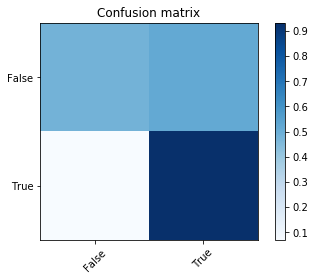

In [74]:
#classes correspond to 0,1
classes = ['False','True']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    
plot_confusion_matrix(confusion, classes, normalize=True)

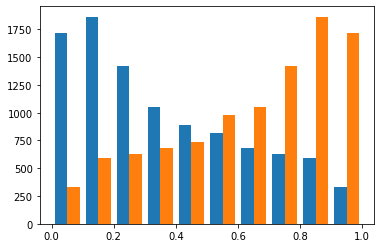

In [75]:
plt.hist(grid.predict_proba(X));

In [76]:
predicted_probabilities = grid.predict_proba(X)[:100]

In [77]:
probabilties = [p[1] for p in predicted_probabilities]

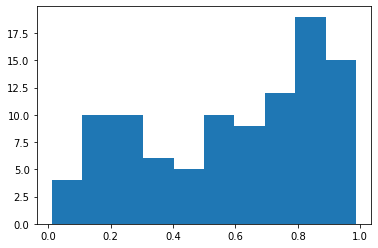

In [78]:
plt.hist(probabilties);

In [69]:
import pickle
s = pickle.dumps(grid)
new_grid = pickle.loads(s)
new_grid.predict(["I hate this product and everyone that eats this crap"])

array([0])

In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, predictions)/1000

array([[0.  , 0.22],
       [0.  , 0.78]])